## Mask model based on original paper code

Node number: 10
Exp number: 10
{5}
before infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
{5}
before infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
{7}
before infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
{0}
before infect {1, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {1, 2, 3, 4, 5, 6, 7, 8, 9}
{3}
before infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
{8}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
{8}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
{2}
before infect {0, 1, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 3, 4, 5, 6, 7, 8, 9}
{5}
before infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
{6}
before infect {0, 1, 2, 3, 4, 5, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 7, 8, 9}


/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead


{6}
before infect {0, 1, 2, 3, 4, 5, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 7, 8, 9}
{9}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
{3}
before infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
{4}
before infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
{4}
before infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
{4}
before infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
{9}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
{2}
before infect {0, 1, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 3, 4, 5, 6, 7, 8, 9}
{1}
before infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
{5}
before infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
{3}
before infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
{3}
before infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 4, 5, 6, 7

{5}
before infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
{9}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
{9}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
{2}
before infect {0, 1, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 3, 4, 5, 6, 7, 8, 9}
{0}
before infect {1, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {1, 2, 3, 4, 5, 6, 7, 8, 9}
{3}
before infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
{9}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
Be infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
In infect {0, 1, 2, 4, 5, 6, 7, 8}
{8}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
{8}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
{6}
before infect {0, 1, 2, 3, 4, 5, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 7, 8, 9}
{3}
before infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
{4}

{8}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
{7}
before infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
{7}
before infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
{7}
before infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
{7}
before infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
{5}
before infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
{8}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
Be infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 7}
Be infect {0, 1, 2, 3, 4, 5, 6, 7}
In infect {0, 1, 2, 3, 4, 5, 6}
Be infect {0, 1, 2, 3, 4, 5, 6}
In infect {0, 1, 2, 3, 5, 6}
{4}
before infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
{3}
before infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
{8}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 

{4}
before infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
{7}
before infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
{2}
before infect {0, 1, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 3, 4, 5, 6, 7, 8, 9}
{8}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
{4}
before infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
{4}
before infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
Be infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
In infect {1, 2, 3, 5, 6, 7, 8, 9}
Be infect {1, 2, 3, 5, 6, 7, 8, 9}
In infect {1, 2, 3, 5, 7, 8, 9}
{6}
before infect {0, 1, 2, 3, 4, 5, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 7, 8, 9}
{9}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
{8}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
{7}
before infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
{5}
before infect {0

{4}
before infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 5, 6, 7, 8, 9}
{3}
before infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
{6}
before infect {0, 1, 2, 3, 4, 5, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 7, 8, 9}
{1}
before infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
{7}
before infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
{1}
before infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
{9}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
{3}
before infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
{3}
before infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
{1}
before infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
{9}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
Be infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
Be infect {0, 1, 3, 4, 5, 6, 7, 8}
In 

{7}
before infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
{3}
before infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 2, 4, 5, 6, 7, 8, 9}
{8}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 9}
{2}
before infect {0, 1, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 3, 4, 5, 6, 7, 8, 9}
Be infect {0, 1, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 4, 5, 6, 7, 8, 9}
Be infect {0, 1, 4, 5, 6, 7, 8, 9}
In infect {0, 1, 5, 6, 7, 8, 9}
Be infect {0, 1, 5, 6, 7, 8, 9}
In infect {0, 1, 5, 6, 7, 9}
Be infect {0, 1, 5, 6, 7, 9}
Be infect {1, 5, 6, 7, 9}
In infect {1, 5, 6, 9}
Be infect {1, 5, 6, 9}
Be infect {1, 6, 9}
In infect {1, 6}
{5}
before infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
{9}
before infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
In infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
Be infect {0, 1, 2, 3, 4, 5, 6, 7, 8}
In infect {0, 1, 2, 3, 5, 6, 7, 8}
Be infect {0, 1, 2, 3, 5, 6, 7, 8}
In infect {0, 1, 2, 5, 6, 7, 8}
Be infect {0, 1, 

{6}
before infect {0, 1, 2, 3, 4, 5, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 7, 8, 9}
{7}
before infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
{1}
before infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
{7}
before infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
In infect {0, 1, 2, 3, 4, 5, 6, 8, 9}
{5}
before infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
{1}
before infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
{0}
before infect {1, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {1, 2, 3, 4, 5, 6, 7, 8, 9}
{0}
before infect {1, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {1, 2, 3, 4, 5, 6, 7, 8, 9}
{5}
before infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
In infect {0, 1, 2, 3, 4, 6, 7, 8, 9}
{1}
before infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {0, 2, 3, 4, 5, 6, 7, 8, 9}
{0}
before infect {1, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {1, 2, 3, 4, 5, 6, 7, 8, 9}
Be infect {1, 2, 3, 4, 5, 6, 7, 8, 9}
In infect {1, 2, 3, 4, 5, 6, 7, 9}
Be 

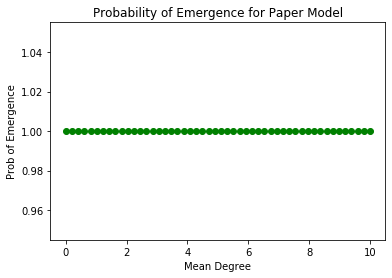

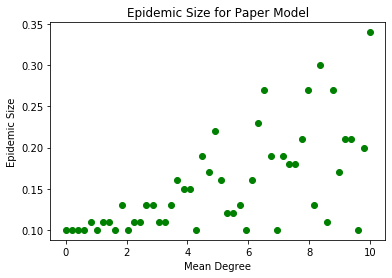

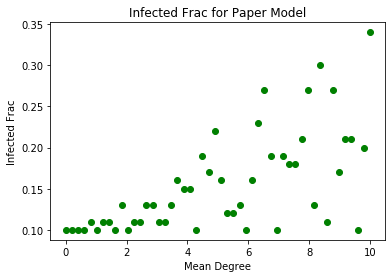

In [26]:
import json
import argparse
import collections
import random
import sys, pdb
import site, os
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
from datetime import datetime
from joblib import Parallel, delayed
import multiprocessing, time
from multiprocessing import Manager



def create_network(mean_degree, num_nodes):
    degree_sequence = np.random.poisson(mean_degree, num_nodes)
    while (np.sum(degree_sequence) % 2 !=0):
        degree_sequence = np.random.poisson(mean_degree, num_nodes)

    return ig.Graph.Degree_Sequence(list(degree_sequence))

def div(x, y):
    if y == 0:
        return 0
    else:
        return x*1.0/y

def runExp(i, mean_degree, num_nodes, T_list, mask_prob):
    network = create_network(mean_degree, num_nodes)
    size = evolution(network, T_list, mask_prob)
    fractionDic[i] = div(size,num_nodes)
#     infectedPerStDic[i] = [div(size1,num_nodes), div(size2,num_nodes)]

def infected_rule(edge_trans_dict, susceptible_nodes):
    new_nodes_list = set()
    if (len(edge_trans_dict.keys()) != 0):
        for node in edge_trans_dict.keys():
            trial_list = edge_trans_dict[node]
            random.shuffle(trial_list) # Shuffle
            for trans in trial_list:
                if random.random() < trans:
                    susceptible_nodes.remove(node)
                    new_nodes_list.add(node)
                    break
    return new_nodes_list

def evolution(g, t_list, mask_prob):
    g.simplify()
    
    node_set = set(g.vs.indices)
    num_nodes = len(node_set)
    
    masks_set = np.random.binomial(1, mask_prob, num_nodes)
    mask_dict = dict(zip(np.linspace(0, num_nodes - 1, num_nodes, dtype = int), masks_set))

    susceptible_nodes = node_set
    strain_set = set([int(np.random.random_integers(0, num_nodes - 1))])
    susceptible_nodes = susceptible_nodes.difference(strain_set)
    new_nodes_list = strain_set
    
    
    while(len(new_nodes_list)):
        edge_trans_dict = collections.defaultdict(list)
        
        
        for node in strain_set:
            strain_neighbors_list = []
            neighbors = g.neighbors(node)
            
            for neighbor_node in neighbors:
                if neighbor_node not in susceptible_nodes: continue

                if  mask_dict[node] == 1 and mask_dict[neighbor_node] == 0:
                    T_edge = t_list[0]
                elif mask_dict[node] == 1 and mask_dict[neighbor_node] == 1:
                    T_edge = t_list[1]
                elif mask_dict[node] == 0 and mask_dict[neighbor_node] == 0:
                    T_edge = t_list[2]
                else:
                    T_edge = t_list[3]
                
                edge_trans_dict[neighbor_node].append(T_edge) 

            
        new_nodes_list = infected_rule(edge_trans_dict, susceptible_nodes)

        strain_set = strain_set.union(new_nodes_list)
    return len(strain_set)

def parse_args(args):
    parser = argparse.ArgumentParser(description = 'Parameters')
    parser.add_argument('-m', type = float, nargs = '+', default = np.arange(1, 10.1, 0.1), help='np.linspace(0.001, 7, 50) (default); list of mean degree: you can type 1 3 5')
    parser.add_argument('-n', type = int, default = 200000, help='10,000 (default); the number of nodes')
    parser.add_argument('-e', type = int, default = 50, help='100 (default); the number of experiments')
    parser.add_argument('-t1', type = float, default = 0.2, help='0.5 (default); the transmissibility of strain-1')
    parser.add_argument('-t2', type = float, default = 0.5, help='0.5 (default); the transmissibility of strain-2')
    parser.add_argument('-m1', type = float, default = 0.9, help='0.5 (default); the mutation probability from 1 to 1')
    parser.add_argument('-m2', type = float, default = 1.0, help='0.5 (default); the mutation probability from 2 to 2')
    parser.add_argument('-thrVal', type = float, default = 0.005, help='0.001 (default); the treshold to consider a component giant')
    parser.add_argument('-numCores', type = int, default = 12, help='number of Cores')
    parser.add_argument('-logName', default = 'logfile', help='The name of the log file')
    parser.add_argument('-i', type = int, default = 1, help='1 (default); starting from type-i node')
    return parser.parse_args(args)

####### Added by Yurun #######
def draw_figures(mean_degree_list, Prob_Emergence, AvgValidSize, AvgSize, ExpPath):
    figure_path = ExpPath + '/' + 'Figures'
    if not os.path.exists(figure_path):
        os.mkdir(figure_path)
    
    ### Probability of Emergence ###    
    plt.figure()
    plt.plot(mean_degree_list, Prob_Emergence, 'go')
    plt.xlabel("Mean Degree")
    plt.ylabel("Prob of Emergence")
    title = "Probability of Emergence for Paper Model"
    plt.title(title)
    plt.savefig(figure_path + '/' + title.replace(" ", "_") + '.png')
    
    ### Epidemic Size ###
    plt.figure()
    plt.plot(mean_degree_list, AvgValidSize, 'go')
    plt.xlabel("Mean Degree")
    plt.ylabel("Epidemic Size")
    title = "Epidemic Size for Paper Model"
    plt.title(title)
    plt.savefig(figure_path + '/' + title.replace(" ", "_") + '.png')
    
    ### Infected Frac ###
    plt.figure()
    plt.plot(mean_degree_list, AvgSize, 'go')
    plt.xlabel("Mean Degree")
    plt.ylabel("Infected Frac")
    title = "Infected Frac for Paper Model"
    plt.title(title)
    plt.savefig(figure_path + '/' + title.replace(" ", "_") + '.png')
    
# paras = parse_args(sys.argv[1:])
# mean_degree_list = paras.m
# t1 = paras.t1
# t2 = paras.t2
# m1 = paras.m1
# m2 = paras.m2
# num_nodes = paras.n
# numExp = paras.e
# start_strain = paras.i
# num_cores = min(paras.numCores,multiprocessing.cpu_count())
# thrVal = paras.thrVal


mean_degree_list = np.linspace(0, 10, 50)

t1 = 0.0048
t2 = 0.032
t3 = 0.32
t4 = 0.048

mask_prob = 0.6

num_nodes = 10000
numExp = 10000

start_strain = 1
num_cores = min(2,multiprocessing.cpu_count())
thrVal = 0.005

print("Node number:", num_nodes)
print("Exp number:", numExp)

T_list = [t1, t2, t3, t4]
ff = open("log1"+'Det','w+')
f = open("log1", 'w+')

########### Added by Yurun ###########
Prob_Emergence = list()
AvgValidSize = list()
AvgSize = list()
StdValidSize = list()
infSt1 = list()
infSt2 = list()

now = datetime.now() # current date and time
timeExp = now.strftime("%m%d%H:%M")
ExpPath = 'Paper_Mask_Results/' + timeExp + '_n' + str(num_nodes) + '_e' + str(numExp)

if not os.path.exists(ExpPath):
    os.makedirs(ExpPath)

#### Paper Code ####
for mean_degree in mean_degree_list:
    a = time.time()
    ttlEpidemicsSize = 0
    numEpidemics = 0
    Epidemics = []
    EpidemicsPerSt = [0,0,0]
    fractionDic = Manager().dict()
    infectedPerStDic = Manager().dict()
    ttlFrac = 0
    
    Parallel(n_jobs = num_cores)(delayed(runExp)(i, mean_degree,num_nodes, T_list, mask_prob) for i in range(numExp))
#     for exp in range(numExp):
#         runExp(exp, mean_degree,num_nodes, T_list, mask_prob) 

    for ii in range(numExp):
        if fractionDic[ii] >= thrVal:
            numEpidemics += 1
            ttlEpidemicsSize += fractionDic[ii]
            Epidemics.append(fractionDic[ii])

        ttlFrac += fractionDic[ii]

    if len(Epidemics) == 0:
        Epidemics.append(0)

    
    ######### Record the results for this Mean Degree ##########    
    Prob_Emergence.append(numEpidemics*1.0/(numExp))
    AvgValidSize.append(div(ttlEpidemicsSize*1.0, numEpidemics))
    AvgSize.append(ttlFrac*1.0/numExp)
    StdValidSize.append(np.std(Epidemics))
    infSt1.append(div(EpidemicsPerSt[0],numEpidemics))
    infSt2.append(div(EpidemicsPerSt[1],numEpidemics))

######### Save the results for all Mean Degrees ########## 
draw_figures(mean_degree_list, Prob_Emergence, AvgValidSize, AvgSize, ExpPath)

setting_path = ExpPath + '/' + 'Settings'
if not os.path.exists(setting_path):
    os.mkdir(setting_path)
    
res_paths = ExpPath + '/' + 'Results'
if not os.path.exists(res_paths):
    os.mkdir(res_paths)

### Experiment Parameters ###
paras = dict()
paras['ExpN'] = numExp
paras['nodeN'] = num_nodes
paras['threshold'] = thrVal

with open(setting_path + '/paras.json', 'w') as fp:
    json.dump(paras, fp)
    
### Degree list ###
np.save(setting_path + '/mean_degree_list.npy', np.array(mean_degree_list)) 
    
### Transmissibilites and mutation probs for Mutation Model ###
np.save(setting_path + '/trans_dict_mu.npy', np.array(T_list)) 


### Results ###
np.save(res_paths + '/Prob_Emergence.npy', np.array(Prob_Emergence)) 
np.save(res_paths + '/AvgValidSize.npy', np.array(AvgValidSize)) 
np.save(res_paths + '/StdValidSize.npy', np.array(StdValidSize)) 
np.save(res_paths + '/infSt1.npy', np.array(infSt1)) 
np.save(res_paths + '/infSt2.npy', np.array(infSt2)) 
    

